In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, copy, timeit, torch
from torch.distributions.bernoulli import Bernoulli 
from tqdm import trange
from HMCfunctions import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Set up neural network:

In [2]:
n_in = 1
n_h1 = 5
# n_h2 = 10
n_out = 2

nn_model = nn.Sequential(nn.Linear(n_in, n_h1),
                         nn.Tanh(),
                         nn.Linear(n_h1, n_out))

* Total number of parameters:

In [3]:
print(sum(p.numel() for p in nn_model.parameters()))

22


* Randomly initialise model parameters:

In [4]:
nn_model.apply(init_normal)

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=2, bias=True)
)

#### Generate some random data:

In [5]:
nobs = 10_000
x = torch.rand(nobs, n_in)
y = np.zeros((nobs, n_out))
y[:,0] = list(np.cos(2*np.pi*x))
y[:,1] = list(np.sin(2*np.pi*x))
y = torch.from_numpy(y).float()
criterion = nn.MSELoss()

* Get dimensions of parameters:

In [6]:
shapes = get_shapes(nn_model)
print("Shapes = ", shapes)

Shapes =  [torch.Size([5, 1]), torch.Size([5]), torch.Size([2, 5]), torch.Size([2])]


###  HMC

* First define the MCMC chain and randomly initialise it:

In [7]:
T = 10_000
chain = []
for shape in shapes :
    chain_shape = list(shape)
    chain_shape.insert(0,T)
    chain.append(torch.randn(chain_shape, requires_grad=False))

* Then run HMC:

In [8]:
delta_leapfrog = 5e-3
n_leapfrog = 25
prior_sigma = 1
error_sigma = 1
nn_model.apply(init_normal)
update_grads(nn_model, x, y)
n_accept = 0

In [9]:
start_time = time()
for t in trange(T) : 
    nn_model, a = HMC_1step(nn_model, n_leapfrog, delta_leapfrog, shapes, x, y, criterion, prior_sigma)
    n_accept += a
    update_grads(nn_model, x, y)
    for (i,param) in enumerate(nn_model.parameters()) :
        chain[i][t] = param.data
        
    if ((t+1) % (int(T/10)) == 0) or (t+1) == T :
        accept_rate = float(n_accept) / float(t+1)
        print("iter %6d/%d after %7.1f sec | accept_rate %.3f" % (
            t+1, T, time() - start_time, accept_rate))

 10%|█         | 1002/10000 [00:54<07:45, 19.34it/s]

iter   1000/10000 after    54.1 sec | accept_rate 0.828


 20%|██        | 2002/10000 [01:44<06:45, 19.71it/s]

iter   2000/10000 after   104.7 sec | accept_rate 0.822


 30%|███       | 3002/10000 [02:35<05:54, 19.75it/s]

iter   3000/10000 after   155.4 sec | accept_rate 0.828


 40%|████      | 4003/10000 [03:26<04:58, 20.11it/s]

iter   4000/10000 after   206.1 sec | accept_rate 0.838


 50%|█████     | 5003/10000 [04:16<04:13, 19.72it/s]

iter   5000/10000 after   256.6 sec | accept_rate 0.843


 60%|██████    | 6004/10000 [05:06<02:55, 22.75it/s]

iter   6000/10000 after   306.5 sec | accept_rate 0.844


 70%|███████   | 7003/10000 [05:56<02:10, 22.89it/s]

iter   7000/10000 after   355.9 sec | accept_rate 0.851


 80%|████████  | 8003/10000 [06:43<01:41, 19.66it/s]

iter   8000/10000 after   403.7 sec | accept_rate 0.854


 90%|█████████ | 9003/10000 [07:36<00:50, 19.70it/s]

iter   9000/10000 after   456.1 sec | accept_rate 0.853


100%|██████████| 10000/10000 [08:24<00:00, 22.67it/s]

iter  10000/10000 after   504.2 sec | accept_rate 0.856


#### ESS's:

In [10]:
ESS, means, Vars = find_ESS(chain, shapes)

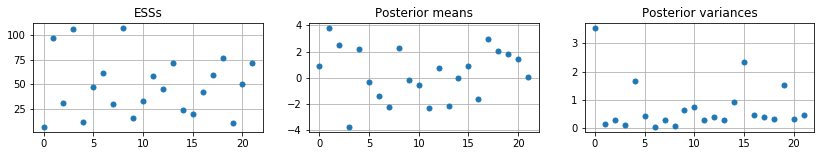

In [11]:
ms = 5
plt.figure(figsize=(14,2))
plt.rcParams['axes.grid'] = True
plt.subplot(131)
plt.plot(ESS, 'o', markersize=ms)
plt.title("ESSs")
plt.subplot(132)
plt.plot(means, 'o', markersize=ms)
plt.title("Posterior means")
plt.subplot(133)
plt.plot(Vars, 'o', markersize=ms)
plt.title("Posterior variances");

In [12]:
ESS

array([  7,  97,  31, 106,  12,  47,  61,  30, 107,  16,  33,  58,  45,
        72,  24,  20,  42,  59,  77,  11,  50,  72])

* There is some bug, because the posterior seems to be basically the prior. Increasing the number of data points does not seem to make any difference, only the prior variance makes a difference. 

### SGD:

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)

In [8]:
for epoch in range(10_000):
    # Forward Propagation
    y_pred = nn_model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if (epoch+1)%1_000 == 0 :
        print('epoch: ', epoch+1,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  1000  loss:  0.4030824899673462
epoch:  2000  loss:  0.3654867112636566
epoch:  3000  loss:  0.3555649220943451
epoch:  4000  loss:  0.3529464900493622
epoch:  5000  loss:  0.3522554636001587
epoch:  6000  loss:  0.3520731031894684
epoch:  7000  loss:  0.35202497243881226
epoch:  8000  loss:  0.3520122468471527
epoch:  9000  loss:  0.3520089089870453
epoch:  10000  loss:  0.35200801491737366


In [22]:
for param in nn_model.parameters() :
    print(param.data)

tensor([[ 0.0465],
        [-1.9168]])
tensor([-0.0425,  0.9472])
